In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os



import tensorflow as tf

2025-06-17 06:44:57.544008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750167897.925083 1330497 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750167897.985300 1330497 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750167898.474792 1330497 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750167898.474836 1330497 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750167898.474839 1330497 computation_placer.cc:177] computation placer alr

In [3]:
current_directory = os.getcwd()
print(current_directory)

/global/u2/k/kberard/SCGSR/Research/Diamond/Testing


In [4]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)
minorized_ref_d = (np.sum(ref_d,axis=2))
minorized_ref_d.shape



(64, 64, 64)


(64, 64)

In [5]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_vmc_samples_1024_0005160960.h5', 'r') as file:
    print("Keys: %s" % file.keys())
    tot_VMC_d = file['density'][:]
#print(ref_d)
print(tot_VMC_d.shape)
minorized_tot_VMC_d = (np.sum(tot_VMC_d,axis=2))
minorized_tot_VMC_d.shape

Keys: <KeysViewHDF5 ['axes', 'centered', 'density', 'density_data_type', 'density_type', 'folding', 'grid', 'nelec', 'points', 'stochastic_type', 'tiling', 'weights']>
(1024, 64, 64, 64)


(1024, 64, 64)

In [6]:
x_test = minorized_tot_VMC_d[900:]
print(x_test.shape)
train_val = minorized_tot_VMC_d[:900]
print(train_val.shape)
sample_mean_ref = np.mean(train_val, axis=0)
print(sample_mean_ref.shape)

(124, 64, 64)
(900, 64, 64)
(64, 64)


In [7]:
from sklearn.model_selection import train_test_split
x_train,x_val = train_test_split(train_val, test_size=.15, train_size=.85, random_state=42, shuffle=True)

In [8]:
print(x_test.shape)
print(x_train.shape)
print(x_val.shape)

(124, 64, 64)
(765, 64, 64)
(135, 64, 64)


In [9]:
y_test = np.zeros((x_test.shape))
y_train = np.zeros((x_train.shape))
y_val = np.zeros((x_val.shape))

for i in range (y_test.shape[0]):
    y_test[i]=sample_mean_ref

for i in range (y_train.shape[0]):
    y_train[i]=sample_mean_ref

for i in range (y_val.shape[0]):
    y_val[i]=sample_mean_ref

# to use DFT ref
"""for i in range (y_test.shape[0]):
    y_test[i]=minorized_ref_d

for i in range (y_train.shape[0]):
    y_train[i]=minorized_ref_d

for i in range (y_val.shape[0]):
    y_val[i]=minorized_ref_d"""

'for i in range (y_test.shape[0]):\n    y_test[i]=minorized_ref_d\n\nfor i in range (y_train.shape[0]):\n    y_train[i]=minorized_ref_d\n\nfor i in range (y_val.shape[0]):\n    y_val[i]=minorized_ref_d'

In [10]:
# Add channel dimension
x_train = x_train[..., np.newaxis]
x_val   = x_val[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

y_train = y_train[..., np.newaxis]
y_val   = y_val[..., np.newaxis]
y_test   = y_test[..., np.newaxis]

In [11]:
# another way of computing JS
"""from scipy.spatial import distance
def jensen_shannon_divergence(P, Q):
    print(P,Q)
    print(type(P))
    P = P.flatten()
    Q = Q.flatten()
    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    return (distance.jensenshannon(P,Q))**2"""

'from scipy.spatial import distance\ndef jensen_shannon_divergence(P, Q):\n    print(P,Q)\n    print(type(P))\n    P = P.flatten()\n    Q = Q.flatten()\n    P = P / np.sum(P)\n    Q = Q / np.sum(Q)\n    return (distance.jensenshannon(P,Q))**2'

In [12]:
import tensorflow as tf

def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


(765, 4096)
Estimated density of test sample 0: 0.0000e+00


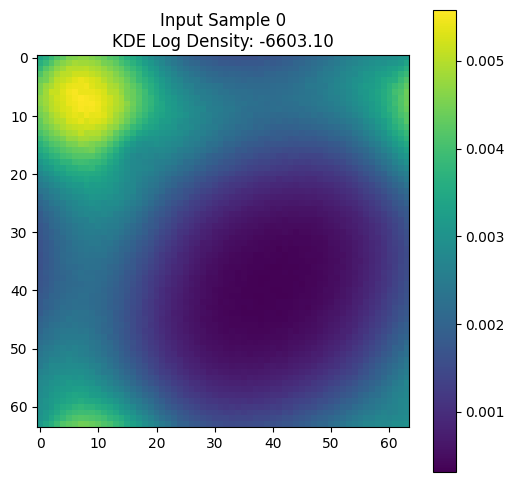

In [17]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# --- Load or generate data ---
# x_train should be of shape (n_samples, height, width, 1)
# Flatten spatial dimensions per sample for KDE
x_train_flat = x_train.reshape(len(x_train), -1)
print(x_train_flat.shape)
# --- KDE Model ---
kde = KernelDensity(kernel='gaussian', bandwidth=2)
kde.fit(x_train_flat)  # Unsupervised fit

# --- Choose a test sample ---
i = 0
test_sample = x_test[i].reshape(1, -1)  # flatten to match training format

# --- Score sample (log probability) ---
log_density = kde.score_samples(test_sample)
density = np.exp(log_density)

print(f"Estimated density of test sample {i}: {density[0]:.4e}")

# --- Optional: Visualize log-likelihood heatmap (difference from mode) ---
# You can also reconstruct a density estimate grid if needed (advanced)

# --- Visualize input image ---
plt.figure(figsize=(6, 6))
plt.imshow(x_test[i, ..., 0], cmap='viridis')
plt.title(f"Input Sample {i}\nKDE Log Density: {log_density[0]:.2f}")
plt.colorbar()
plt.show()


Flattened train shape: (765, 4096)
Estimated density of test sample 0: 0.0000e+00
Round-trip reconstruction MSE: 8.9209e+00


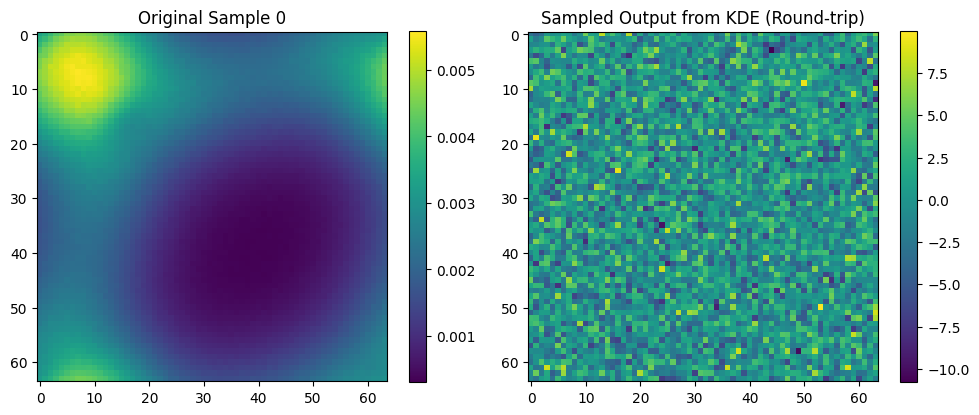

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error

# --- Flatten training data ---
x_train_flat = x_train.reshape(len(x_train), -1)  # shape: (n_samples, H*W)
print(f"Flattened train shape: {x_train_flat.shape}")

# --- Fit KDE on full-dimensional space ---
kde = KernelDensity(kernel='gaussian', bandwidth=3)
kde.fit(x_train_flat)

# --- Test sample ---
i = 0
x_test_flat = x_test[i].reshape(1, -1)

# --- Score the test sample ---
log_density = kde.score_samples(x_test_flat)
density = np.exp(log_density)[0]
print(f"Estimated density of test sample {i}: {density:.4e}")

# --- Round-trip sample ---
sampled_flat = kde.sample(1)  # shape: (1, H*W)
sampled_img = sampled_flat.reshape(x_test.shape[1:])  # shape: (H, W, 1)

# --- Compare MSE between original and round-trip ---
mse = mean_squared_error(x_test_flat, sampled_flat)
print(f"Round-trip reconstruction MSE: {mse:.4e}")

# --- Plot input vs round-trip sampled image ---
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(x_test[i, ..., 0], cmap='viridis')
plt.title(f"Original Sample {i}")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(sampled_img[..., 0], cmap='viridis')
plt.title("Sampled Output from KDE (Round-trip)")
plt.colorbar()

plt.tight_layout()
plt.show()
